In [387]:
import numpy as np
import pandas as pd

import matplotlib
import matplotlib.image as img
import matplotlib.pyplot as plt
import seaborn as sns
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score as r2, roc_auc_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.preprocessing import RobustScaler

Загрузка данных

Описание датасета

Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры

In [274]:
test = pd.read_csv("test.csv")
test.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,B,B,11,2748,1,NaN,0,0,B
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,B,B,6,1437,3,NaN,0,2,B
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,B,B,30,7538,87,4702.0,5,5,B
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,B,B,23,4583,3,NaN,3,3,B
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,B,B,2,629,1,NaN,0,0,A


In [275]:
train = pd.read_csv("train.csv")
train.head(5)

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
0,14038,35,2.0,47.981561,29.442751,6.0,7,9.0,1969,0.089040,B,B,33,7976,5,NaN,0,11,B,184966.930730
1,15053,41,3.0,65.683640,40.049543,8.0,7,9.0,1978,0.000070,B,B,46,10309,1,240.0,1,16,B,300009.450063
2,4765,53,2.0,44.947953,29.197612,0.0,8,12.0,1968,0.049637,B,B,34,7759,0,229.0,1,3,B,220925.908524
3,5809,58,2.0,53.352981,52.731512,9.0,8,17.0,1977,0.437885,B,B,23,5735,3,1084.0,0,5,B,175616.227217
4,10783,99,1.0,39.649192,23.776169,7.0,11,12.0,1976,0.012339,B,B,35,5776,1,2078.0,2,4,B,150226.531644


In [276]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [277]:
train = reduce_mem_usage(train)

Memory usage of dataframe is 1.53 MB
Memory usage after optimization is: 0.49 MB
Decreased by 68.1%


In [278]:
train.dtypes

Id                  int16
DistrictId          int16
Rooms             float32
Square            float32
LifeSquare        float32
KitchenSquare     float32
Floor                int8
HouseFloor        float32
HouseYear           int32
Ecology_1         float32
Ecology_2        category
Ecology_3        category
Social_1             int8
Social_2            int16
Social_3            int16
Healthcare_1      float32
Helthcare_2          int8
Shops_1              int8
Shops_2          category
Price             float32
dtype: object

Обзор данных

Целевая переменная


Цена квартиры

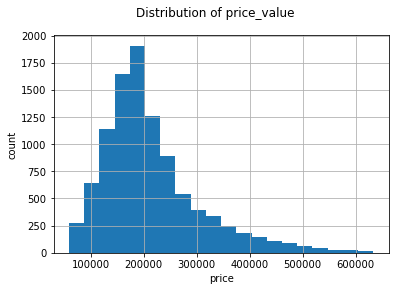

In [279]:
train['Price'].hist(density=False, bins=20)
plt.ylabel('count')
plt.xlabel('price')

plt.suptitle('Distribution of price_value')
plt.show()

Согласно графику целевая переменна имеет нормальное распределение без видимых выбросов

In [280]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype   
---  ------         --------------  -----   
 0   Id             10000 non-null  int16   
 1   DistrictId     10000 non-null  int16   
 2   Rooms          10000 non-null  float32 
 3   Square         10000 non-null  float32 
 4   LifeSquare     7887 non-null   float32 
 5   KitchenSquare  10000 non-null  float32 
 6   Floor          10000 non-null  int8    
 7   HouseFloor     10000 non-null  float32 
 8   HouseYear      10000 non-null  int32   
 9   Ecology_1      10000 non-null  float32 
 10  Ecology_2      10000 non-null  category
 11  Ecology_3      10000 non-null  category
 12  Social_1       10000 non-null  int8    
 13  Social_2       10000 non-null  int16   
 14  Social_3       10000 non-null  int16   
 15  Healthcare_1   5202 non-null   float32 
 16  Helthcare_2    10000 non-null  int8    
 17  Shops_1        10000 non-null  i

In [281]:
train.isna().sum()

Id                  0
DistrictId          0
Rooms               0
Square              0
LifeSquare       2113
KitchenSquare       0
Floor               0
HouseFloor          0
HouseYear           0
Ecology_1           0
Ecology_2           0
Ecology_3           0
Social_1            0
Social_2            0
Social_3            0
Healthcare_1     4798
Helthcare_2         0
Shops_1             0
Shops_2             0
Price               0
dtype: int64

In [282]:
train.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315712,37.199596,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904419,1.319500,4.231300,214139.218750
std,4859.01902,43.587592,0.839523,21.058718,86.241112,28.561113,5.241148,6.776192,2.005003e+05,0.119026,17.532614,4006.799803,23.831875,1021.518982,1.493601,4.806341,92872.304688
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.777344
25%,4169.50000,20.000000,1.000000,41.774879,22.769833,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.628906
50%,8394.50000,36.000000,2.000000,52.513309,32.781261,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.648438
75%,12592.50000,75.000000,2.000000,65.900627,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.460938
max,16798.00000,209.000000,19.000000,641.065186,7480.592285,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.437500


Согласно полученной информации в датасетее переменные LifeSquare, Healthcare_1 имеет пропуски.

Рассмотрим далее каждуюперемнную более детально.


Rooms

In [283]:
train['Rooms'].unique()

array([ 2.,  3.,  1.,  4., 10.,  0.,  5., 19.,  6.], dtype=float32)

Можем видеть, что  в датасете присутствую квартиры с очень большим количеством комнат ( 10, 19) или без комнат 0. Заменим эти значения на медиану.

In [284]:
train.loc[train['Rooms'].isin([0, 10, 19]), 'Rooms'] = train['Rooms'].median()

In [285]:
train['Rooms'].value_counts()

2.0    3891
1.0    3705
3.0    2235
4.0     150
5.0      18
6.0       1
Name: Rooms, dtype: int64

DistrictId

In [286]:
train['Id'] = train['Id'].astype(str)
train['DistrictId'] = train['DistrictId'].astype(str)
train_district = train['DistrictId'].value_counts().reset_index().rename(columns = {'index':'DistrictId', 'DistrictId':'DistrictSize'})
train = train.merge(train_district, on='DistrictId', how='left')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,B,33,7976,5,NaN,0,11,B,184966.937500,22
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,B,46,10309,1,240.0,1,16,B,300009.437500,87
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,...,B,34,7759,0,229.0,1,3,B,220925.906250,174
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,B,23,5735,3,1084.0,0,5,B,175616.234375,179
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,B,35,5776,1,2078.0,2,4,B,150226.531250,97


На основе переменной DistrictId создадим новую переменную DistrictSize, характеризующую количество продаваемых квартир в данном районе (популярность района)

In [287]:
train_district

,DistrictId,DistrictSize
0,27,851
1,1,652
2,23,565
3,6,511
4,9,294
...,...,...
200,174,1
201,205,1
202,207,1
203,199,1


Введем новую бинарную переменную IsDistrictLarge, харакеризующую густонаселенность района

In [288]:
train['IsDistrictLarge'] = (train['DistrictSize'] > 100).astype(int)
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,33,7976,5,NaN,0,11,B,184966.937500,22,0
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,46,10309,1,240.0,1,16,B,300009.437500,87,0
2,4765,53,2.0,44.947952,29.197611,0.0,8,12.0,1968,0.049637,...,34,7759,0,229.0,1,3,B,220925.906250,174,1
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,23,5735,3,1084.0,0,5,B,175616.234375,179,1
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,35,5776,1,2078.0,2,4,B,150226.531250,97,0


KitchenSquare

In [289]:
max_sq = train.loc[train['KitchenSquare'] > 122, 'KitchenSquare']
max_sq

1064    2014.0
8584    1970.0
9895     123.0
Name: KitchenSquare, dtype: float32

В датасете присутствуют значения площади кухни больше (меньше) реальных значений, заменим их на максимально и минимально реальные

In [290]:
train.loc[train['KitchenSquare'] > 123, 'KitchenSquare'] = 123

In [291]:
train.loc[train['KitchenSquare'] < 6, 'KitchenSquare'] = 6

Также поступим с минимальным значение общей площади, приблизим его к более реальному значению

In [292]:
train.loc[train['Square'] < 30, 'Square'] = 30

LifeSquare

Для начала обработаем пропуски значений LifeSquare

Для этого вычислим медиану разности общей площади и жилой площади и площади кухни

In [293]:
square_med_diff = (train.loc[train['LifeSquare'].notnull(), 'Square'] -\
                   train.loc[train['LifeSquare'].notnull(), 'LifeSquare'] -\
                   train.loc[train['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff

11.151870727539062

Заполним пустые значения LifeSquare разностью общей площади, площади кухни и square_med_diff

In [294]:
train.loc[train['LifeSquare'].isnull(), 'LifeSquare'] = train.loc[train['LifeSquare'].isnull(), 'Square'] -\
train.loc[train['LifeSquare'].isnull(), 'KitchenSquare'] - square_med_diff

In [295]:
max_sq = train.loc[train['LifeSquare'] > 500, 'LifeSquare']
max_sq

4262     587.554138
4328    7480.592285
6977     638.163208
Name: LifeSquare, dtype: float32

Приблизим максимальное и минимальное значение жилой площади к реальной

In [296]:
train.loc[train['LifeSquare'] > 638, 'LifeSquare'] = 638

In [297]:
train.loc[train['LifeSquare'] < 15, 'LifeSquare'] = 15

In [298]:
train['LifeSquare'].describe()

count    10000.000000
mean        37.976135
std         21.534893
min         15.000000
25%         23.565897
50%         33.566135
75%         46.573438
max        638.000000
Name: LifeSquare, dtype: float64

Проверим есть ли значение общей площади квартиры, которые меньше суммы жилой площади и площади кухни

In [346]:
sq_check = train.loc[train['Square'] < train['LifeSquare']+train['KitchenSquare']].index
sq_check

Int64Index([], dtype='int64')

In [345]:
train.loc[sq_check, 'Square'] = train.loc[sq_check, 'LifeSquare']+train.loc[sq_check,'KitchenSquare']+square_med_diff

HouseFloor

In [300]:
train['HouseFloor'].sort_values().unique()

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        36.,  37.,  38.,  39.,  40.,  44.,  45.,  47.,  48.,  99., 117.],
      dtype=float32)

заменим нулевое значение этажности дома на минимальное

In [301]:
train.loc[train['HouseFloor'] == 0, 'HouseFloor'] = 1

Floor

In [302]:
train['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 37, 42],
      dtype=int8)

Проверим ели в датасете значения этажа квартиры большие этажности дома

In [303]:
floor_outliers = train[train['Floor'] > train['HouseFloor']]
floor_outliers

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge
7,11993,74,2.0,80.312927,63.161057,6.0,14,1.0,1977,0.075779,...,6,1437,3,NaN,0,2,B,221244.156250,114,1
14,10953,27,1.0,53.769096,52.408028,6.0,5,4.0,1977,0.072158,...,2,629,1,NaN,0,0,A,140647.562500,851,1
16,2119,27,2.0,49.360649,31.993963,6.0,6,5.0,1983,0.051815,...,5,1227,0,NaN,0,0,B,117000.382812,851,1
21,11935,27,2.0,64.711838,47.559967,6.0,15,1.0,1977,0.211401,...,9,1892,0,NaN,0,1,B,127200.023438,851,1
23,6641,54,3.0,118.907608,101.755737,6.0,2,1.0,1977,0.006076,...,30,5285,0,645.0,6,6,B,571069.062500,37,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9984,2237,52,3.0,64.074974,47.633427,6.0,11,9.0,1983,0.371149,...,34,7065,1,750.0,2,5,B,226434.875000,143,1
9985,16159,27,1.0,38.968338,21.816467,6.0,10,1.0,1977,0.211401,...,9,1892,0,NaN,0,1,B,95529.570312,851,1
9989,4145,96,3.0,90.055229,47.860229,11.0,26,24.0,2005,0.041116,...,53,14892,4,NaN,1,4,B,441108.906250,71,0
9991,11553,3,3.0,101.622795,51.628780,12.0,18,17.0,2000,0.265089,...,37,5288,0,1937.0,3,2,B,212883.500000,82,0


Заменим эти значения на случайные величины из отрезка от 1 до этажности дома

In [304]:
np.random.seed(42)
floor_outliers = train[train['Floor'] > train['HouseFloor']].index
train.loc[floor_outliers, 'Floor'] = train.loc[floor_outliers, 'HouseFloor'].apply( lambda x: random.randint(1, x))

HouseYear

In [305]:
train['HouseYear'].value_counts()

1977        2652
2017         308
2016         305
2015         299
2014         210
            ... 
1928           1
1947           1
1914           1
4968           1
20052011       1
Name: HouseYear, Length: 97, dtype: int64

Заменим ошибочные данные года постройки дома

In [306]:
train.loc[train['HouseYear'] == 4968, 'HouseYear'] = 1968

In [235]:
train.loc[train['HouseYear'] == 20052011, 'HouseYear'] = 2005

Healthcare_1


Заменим пропуски Healthcare_1 медианой этой переменной

In [307]:
train.loc[train['Healthcare_1'].isnull(), 'Healthcare_1'] = train['Healthcare_1'].median()

Ecology_2, Ecology_3, Shops_2

Строковые переменные имеющие значения либо А, либо В. Заменим из бинарными значениями 0, 1

In [308]:
train['Ecology_2'].unique()

['B', 'A']
Categories (2, object): ['B', 'A']

In [309]:
train['Ecology_3'].unique()

['B', 'A']
Categories (2, object): ['B', 'A']

In [310]:
train['Shops_2'].unique()

['B', 'A']
Categories (2, object): ['B', 'A']

In [311]:
train['Ecology_2_new'] = 0
train.loc[train['Ecology_2'] == 'B', 'Ecology_2_new'] = 1

In [312]:
train['Ecology_3_new'] = 0
train.loc[train['Ecology_3'] == 'B', 'Ecology_3_new'] = 1

In [313]:
train['Shops_2_new'] = 0
train.loc[train['Shops_2'] == 'B', 'Shops_2_new'] = 1

MedPriceByDistrict

Введем новую переменную MedPriceByDistrict характеризующую среднию цену для квартир в данном районе в зависимости от комнатности

In [314]:
med_price_by_district = train.groupby(['DistrictId', 'Rooms'], as_index=False).agg({'Price':'median'})\
                       .rename(columns={'Price':'MedPriceByDistrict'})

med_price_by_district.head()

,DistrictId,Rooms,MedPriceByDistrict
0,0,1.0,142799.437500
1,0,2.0,176210.812500
2,0,3.0,300610.375000
3,1,1.0,146735.671875
4,1,2.0,202666.312500


In [315]:
train = train.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')
train.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Helthcare_2,Shops_1,Shops_2,Price,DistrictSize,IsDistrictLarge,Ecology_2_new,Ecology_3_new,Shops_2_new,MedPriceByDistrict
0,14038,35,2.0,47.981560,29.442751,6.0,7,9.0,1969,0.089040,...,0,11,B,184966.937500,22,0,1,1,1,207786.125000
1,15053,41,3.0,65.683640,40.049541,8.0,7,9.0,1978,0.000070,...,1,16,B,300009.437500,87,0,1,1,1,300009.437500
2,4765,53,2.0,44.947952,29.197611,6.0,8,12.0,1968,0.049637,...,1,3,B,220925.906250,174,1,1,1,1,263206.218750
3,5809,58,2.0,53.352982,52.731510,9.0,8,17.0,1977,0.437885,...,0,5,B,175616.234375,179,1,1,1,1,166809.671875
4,10783,99,1.0,39.649193,23.776169,7.0,11,12.0,1976,0.012339,...,2,4,B,150226.531250,97,0,1,1,1,158539.062500


In [316]:
train['MedPriceByDistrict']

0       207786.125000
1       300009.437500
2       263206.218750
3       166809.671875
4       158539.062500
            ...      
9995    233599.109375
9996    171162.187500
9997    118327.093750
9998    187966.406250
9999    178780.609375
Name: MedPriceByDistrict, Length: 10000, dtype: float32

Перенесем обработку данных на тестовый датасет

In [317]:
test.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1
count,5000.000000,5000.000000,5000.000000,5000.000000,3959.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,2623.000000,5000.00000,5000.000000
mean,8412.595400,51.279200,1.910000,56.449500,36.158810,5.976800,8.632000,12.601000,1984.392600,0.119874,24.933800,5406.900000,8.262600,1146.657263,1.31940,4.242800
std,4832.674037,44.179466,0.838594,19.092787,17.825287,9.950018,5.483228,6.789213,18.573149,0.120070,17.532202,4026.614773,23.863762,1044.744231,1.47994,4.777365
min,1.000000,0.000000,0.000000,1.378543,0.333490,0.000000,1.000000,0.000000,1908.000000,0.000000,0.000000,168.000000,0.000000,0.000000,0.00000,0.000000
25%,4221.750000,21.000000,1.000000,41.906231,23.092026,1.000000,4.000000,9.000000,1973.000000,0.019509,6.000000,1564.000000,0.000000,325.000000,0.00000,1.000000
50%,8320.500000,37.000000,2.000000,52.921340,32.925087,6.000000,7.000000,12.000000,1977.000000,0.072158,25.000000,5285.000000,2.000000,900.000000,1.00000,3.000000
75%,12598.250000,77.000000,2.000000,66.285129,45.174091,9.000000,12.000000,17.000000,2000.000000,0.195781,36.000000,7287.000000,5.000000,1548.000000,2.00000,6.000000
max,16795.000000,212.000000,17.000000,223.453689,303.071094,620.000000,78.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.00000,23.000000


In [318]:
test['Rooms'].unique()

array([ 2.,  1.,  3.,  4.,  5.,  6.,  0., 17.])

In [319]:
train.loc[train['Rooms'].isin([0, 17]), 'Rooms'] = train['Rooms'].median()

In [320]:
test['DistrictId'] = test['DistrictId'].astype(str)

In [321]:
test = test.merge(med_price_by_district, on=['DistrictId', 'Rooms'], how='left')

In [322]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   object 
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          3959 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        2623 non-null   float64
 16  Helthc

In [323]:
test.loc[test['MedPriceByDistrict'].isnull(), 'MedPriceByDistrict'] = test['MedPriceByDistrict'].median()

In [324]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 0 to 4999
Data columns (total 20 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Id                  5000 non-null   int64  
 1   DistrictId          5000 non-null   object 
 2   Rooms               5000 non-null   float64
 3   Square              5000 non-null   float64
 4   LifeSquare          3959 non-null   float64
 5   KitchenSquare       5000 non-null   float64
 6   Floor               5000 non-null   int64  
 7   HouseFloor          5000 non-null   float64
 8   HouseYear           5000 non-null   int64  
 9   Ecology_1           5000 non-null   float64
 10  Ecology_2           5000 non-null   object 
 11  Ecology_3           5000 non-null   object 
 12  Social_1            5000 non-null   int64  
 13  Social_2            5000 non-null   int64  
 14  Social_3            5000 non-null   int64  
 15  Healthcare_1        2623 non-null   float64
 16  Helthc

In [326]:
test['Id'] = test['Id'].astype(str)
test['DistrictId'] = test['DistrictId'].astype(str)
test_district = test['DistrictId'].value_counts().reset_index().rename(columns = {'index':'DistrictId', 'DistrictId':'DistrictSize'})
test = test.merge(test_district, on='DistrictId', how='left')
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MedPriceByDistrict,DistrictSize
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,B,11,2748,1,NaN,0,0,B,166809.671875,91
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,...,B,6,1437,3,NaN,0,2,B,243031.687500,61
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,B,30,7538,87,4702.0,5,5,B,197049.234375,2
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,B,23,4583,3,NaN,3,3,B,222227.593750,49
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,B,2,629,1,NaN,0,0,A,118327.093750,391


In [327]:
test['IsDistrictLarge'] = (test['DistrictSize'] > 100).astype(int)
test.head()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MedPriceByDistrict,DistrictSize,IsDistrictLarge
0,725,58,2.0,49.882643,33.432782,6.0,6,14.0,1972,0.310199,...,11,2748,1,NaN,0,0,B,166809.671875,91,0
1,15856,74,2.0,69.263183,NaN,1.0,6,1.0,1977,0.075779,...,6,1437,3,NaN,0,2,B,243031.687500,61,0
2,5480,190,1.0,13.597819,15.948246,12.0,2,5.0,1909,0.000000,...,30,7538,87,4702.0,5,5,B,197049.234375,2,0
3,15664,47,2.0,73.046609,51.940842,9.0,22,22.0,2007,0.101872,...,23,4583,3,NaN,3,3,B,222227.593750,49,0
4,14275,27,1.0,47.527111,43.387569,1.0,17,17.0,2017,0.072158,...,2,629,1,NaN,0,0,A,118327.093750,391,1


In [329]:
test.loc[test['Square'] < 30, 'Square'] = 30

In [330]:
test.loc[test['KitchenSquare'] > 123, 'KitchenSquare'] = 123

In [331]:
test.loc[test['KitchenSquare'] < 6, 'KitchenSquare'] = 6

In [332]:
square_med_diff_test = (test.loc[test['LifeSquare'].notnull(), 'Square'] -\
                   test.loc[test['LifeSquare'].notnull(), 'LifeSquare'] -\
                   test.loc[test['LifeSquare'].notnull(), 'KitchenSquare']).median()

square_med_diff_test

11.125620544295444

In [333]:
test.loc[test['LifeSquare'].isnull(), 'LifeSquare'] = test.loc[test['LifeSquare'].isnull(), 'Square'] -\
test.loc[test['LifeSquare'].isnull(), 'KitchenSquare'] - square_med_diff_test

In [335]:
sq_check = test.loc[test['Square'] < test['LifeSquare']+test['KitchenSquare']]
sq_check.describe()

,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,MedPriceByDistrict,DistrictSize,IsDistrictLarge
count,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,597.000000,235.000000,597.000000,597.000000,597.000000,597.000000,597.000000
mean,1.825796,59.661357,59.301804,8.283082,9.705193,14.102178,1998.991625,0.103857,15.916248,3635.187605,8.954774,813.604255,0.867672,3.463987,194697.640625,198.120603,0.606365
std,0.806728,20.049525,22.599955,9.219650,5.833845,7.970454,19.791317,0.114710,16.707201,3794.238330,29.848999,661.023637,1.371171,5.330436,76265.406250,141.928220,0.488965
min,0.000000,30.000000,17.251768,6.000000,1.000000,0.000000,1931.000000,0.000000,0.000000,168.000000,0.000000,30.000000,0.000000,0.000000,102069.273438,2.000000,0.000000
25%,1.000000,42.898634,42.655813,6.000000,5.000000,9.000000,1977.000000,0.011654,2.000000,629.000000,0.000000,435.000000,0.000000,0.000000,142883.015625,61.000000,0.000000
50%,2.000000,57.345981,57.151842,6.000000,9.000000,17.000000,2014.000000,0.069753,6.000000,1564.000000,1.000000,645.000000,0.000000,1.000000,178583.578125,257.000000,1.000000
75%,2.000000,70.109700,69.263085,9.000000,13.000000,17.000000,2016.000000,0.195781,27.000000,6398.000000,3.000000,1046.000000,1.000000,5.000000,213915.968750,344.000000,1.000000
max,5.000000,168.729035,303.071094,123.000000,32.000000,99.000000,2020.000000,0.521867,74.000000,19083.000000,141.000000,3300.000000,6.000000,23.000000,511248.312500,391.000000,1.000000


In [350]:
sq_check = test.loc[test['Square'] < test['LifeSquare']+test['KitchenSquare']].index
sq_check

Int64Index([], dtype='int64')

In [349]:
test.loc[sq_check, 'Square'] = test.loc[sq_check, 'LifeSquare']+test.loc[sq_check,'KitchenSquare']+square_med_diff_test

In [351]:
test['HouseFloor'].sort_values().unique()

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11., 12.,
       13., 14., 15., 16., 17., 18., 19., 20., 21., 22., 23., 24., 25.,
       26., 27., 28., 29., 30., 31., 32., 33., 34., 36., 37., 39., 40.,
       48., 99.])

In [352]:
test.loc[test['HouseFloor'] == 0, 'HouseFloor'] = 1

In [353]:
test['Floor'].sort_values().unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 31, 32, 33, 34, 38, 46,
       78], dtype=int64)

In [354]:
floor_outliers = test[test['Floor'] > test['HouseFloor']]
floor_outliers

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,...,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,MedPriceByDistrict,DistrictSize,IsDistrictLarge
1,15856,74,2.0,69.263183,52.137563,6.0,6,1.0,1977,0.075779,...,6,1437,3,NaN,0,2,B,243031.687500,61,0
10,15975,61,3.0,64.543658,42.651541,7.0,10,9.0,1981,0.300323,...,52,10311,6,NaN,1,9,B,262307.531250,64,0
14,5214,27,1.0,37.555197,20.429576,6.0,5,1.0,1977,0.211401,...,9,1892,0,NaN,0,1,B,118327.093750,391,1
22,12694,27,3.0,83.670032,46.358356,6.0,8,1.0,2015,0.072158,...,2,629,1,NaN,0,0,A,213530.781250,391,1
24,8968,27,2.0,69.849239,52.723619,6.0,3,1.0,1977,0.011654,...,4,915,0,NaN,0,0,B,165700.343750,391,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4976,4723,95,1.0,45.542940,28.417319,6.0,6,1.0,1977,0.000699,...,14,3369,24,4129.0,0,3,B,359932.062500,11,0
4989,2591,39,2.0,44.203592,30.191691,6.0,10,9.0,1972,0.428826,...,25,5011,8,730.0,0,2,B,197795.578125,29,0
4993,14562,113,2.0,46.627882,27.058739,6.0,6,5.0,1969,0.307467,...,30,5048,9,325.0,2,5,B,216242.234375,27,0
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,...,74,19083,2,NaN,5,15,B,315198.843750,36,0


In [355]:
np.random.seed(42)
floor_outliers = test[test['Floor'] > test['HouseFloor']].index
test.loc[floor_outliers, 'Floor'] = test.loc[floor_outliers, 'HouseFloor'].apply( lambda x: random.randint(1, x))

In [356]:
test['HouseYear'].sort_values().unique()

array([1908, 1909, 1910, 1911, 1912, 1914, 1917, 1918, 1920, 1926, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1937, 1938, 1939,
       1940, 1941, 1943, 1948, 1949, 1950, 1952, 1953, 1954, 1955, 1956,
       1957, 1958, 1959, 1960, 1961, 1962, 1963, 1964, 1965, 1966, 1967,
       1968, 1969, 1970, 1971, 1972, 1973, 1974, 1975, 1976, 1977, 1978,
       1979, 1980, 1981, 1982, 1983, 1984, 1985, 1986, 1987, 1988, 1989,
       1990, 1991, 1992, 1993, 1994, 1995, 1996, 1997, 1998, 1999, 2000,
       2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020], dtype=int64)

In [357]:
test.loc[test['Healthcare_1'].isnull(), 'Healthcare_1'] = test['Healthcare_1'].median()

In [358]:
test['Ecology_2_new'] = 0
test.loc[test['Ecology_2'] == 'B', 'Ecology_2_new'] = 1

In [359]:
test['Ecology_3_new'] = 0
test.loc[test['Ecology_3'] == 'B', 'Ecology_3_new'] = 1

In [360]:
test['Shops_2_new'] = 0
test.loc[test['Shops_2'] == 'B', 'Shops_2_new'] = 1

Отбор признаков

In [361]:
train.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price',
 'DistrictSize',
 'IsDistrictLarge',
 'Ecology_2_new',
 'Ecology_3_new',
 'Shops_2_new',
 'MedPriceByDistrict']

In [362]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2_new', 'Ecology_3_new', 'Social_1', 'Social_2', 'Social_3',
                 'Healthcare_1', 'Helthcare_2', 'Shops_1', 'Shops_2_new']

new_feature_names = ['IsDistrictLarge', 'MedPriceByDistrict']

target_name = 'Price'

In [363]:
train.shape

(10000, 26)

In [364]:
test.shape

(5000, 25)

Разобьем модель на тренировочную и валидационную выборку

In [365]:
X = train[feature_names + new_feature_names]
y = train[target_name]

In [366]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.33, shuffle=True, random_state=47
)

Проведем обучение модели методом RandomForestRegressor

In [382]:
rf_model = RandomForestRegressor(max_depth=8, min_samples_split=50, n_estimators=200, random_state=42)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=8, min_samples_split=50, n_estimators=200,
                      random_state=42)

In [368]:
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):

    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))

    plt.figure(figsize=(18,10))
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Сравним оценки r2 для результатов обучения

Train R2:	0.785
Test R2:	0.737


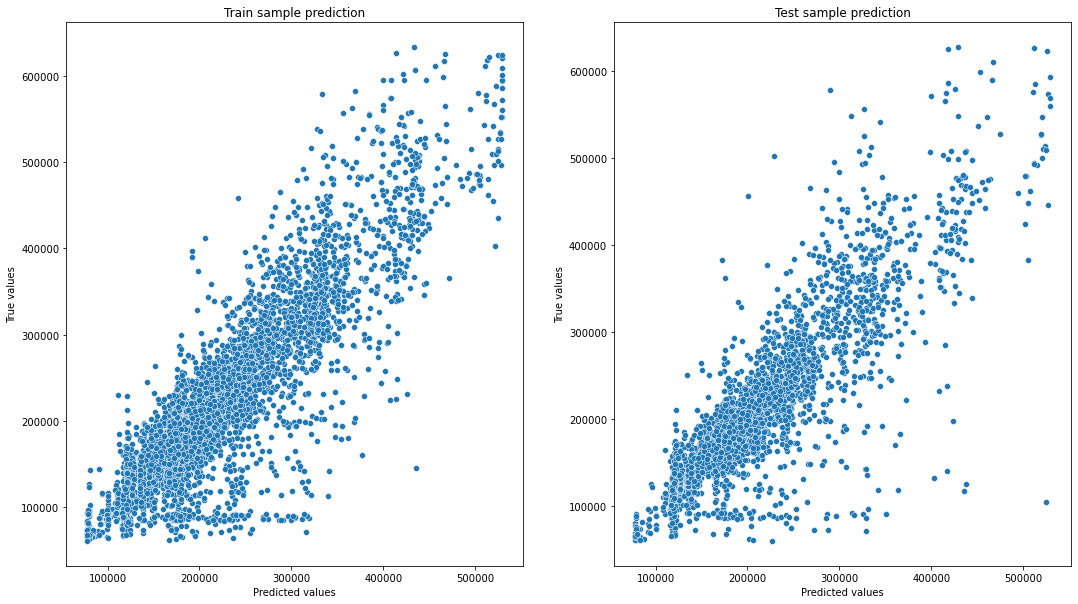

In [383]:
y_train_preds = rf_model.predict(X_train)
y_test_preds = rf_model.predict(X_test)

evaluate_preds(y_train, y_train_preds, y_test, y_test_preds)


In [388]:
cv_score = cross_val_score(
    rf_model,
    X.fillna(-9999),
    y, scoring='r2',
    cv=KFold(n_splits=5, shuffle=True, random_state=21)
)
cv_score

array([0.73942154, 0.71948433, 0.71436273, 0.74765048, 0.72283159])

In [389]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
18,MedPriceByDistrict,0.774807
1,Square,0.104085
12,Social_3,0.020820
3,KitchenSquare,0.019864
5,HouseFloor,0.014225
11,Social_2,0.010699
2,LifeSquare,0.010353
6,HouseYear,0.010040
13,Healthcare_1,0.008389
10,Social_1,0.006531


Предсказание результатов на тестовой выборке

In [396]:
X_test_t = test[feature_names + new_feature_names]

In [397]:
Price_test_preds = rf_model.predict(X_test_t)

In [398]:
Price_test_preds

array([171387.4515371 , 256204.60013685, 203262.67759815, ...,
       327390.73639111, 181274.77075065, 177214.75096733])

Запишем в результирующий файл

In [399]:
test_id = test["Id"]
pred_df = pd.DataFrame()
pred_df["Id"] = test_id
pred_df["Price"] = Price_test_preds
assert pred_df.shape[0] == 5000, f"Real pred-shape = {pred_df.shape[0]}, Expected pred-shape = 5000"

pred_df.to_csv("./MMikhaylova_predictions_.csv", index=False)

In [400]:
pred_df = pd.read_csv("./MMikhaylova_predictions_.csv")
pred_df.head(n=3)

,Id,Price
0,725,171387.451537
1,15856,256204.600137
2,5480,203262.677598


In [395]:
test.shape[0]

5000